In [1]:
# TODO: Build a gdf with the Madrid districts and two extra columns: 
        # Income Data: Income per capita or median income by district.
        # Ethnicity Data: Proportion of different ethnic groups per district. 
                # If you have multiple ethnic groups in your dataset, you might want to handle this differently, like with a separate column for each group.

I am calculating Moran's I for mean household rent data (and possibly more types of data, like walknig time to amenities or something like that) to see if the distribution of rent in the districts of Madrid is dispersed randomly or if there is any clustering.

To calculate Moran's I, I use the PYSAL library to first calculate the weights (in this case, Queen, but I need to justify why and do some more research on this). Then, I apply the Moran's I equation by using a built-in method: mi_income = Moran(merged['Total'], w)

In [39]:
import config as cfg
import pandas as pd 
import geopandas as gpd
# for plotting
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.pyplot as plt
import mapclassify
# for Moran's I
import numpy as np
from libpysal.weights import Queen
from esda.moran import Moran, Moran_Local

In [2]:
mobility_data = cfg.MOBILITY_DATA
geometria_data = cfg.GEOMETRIA_DATA
zonificacion_data = cfg.ZONIFICACION_DATA

In [42]:
nombres_distritos = pd.read_csv(zonificacion_data / 'distritos/PROCESSED_nombres_distritos.csv')
gdf = gpd.read_file(zonificacion_data / 'distritos/madrid_gdf.geojson')
renta = pd.read_csv('data/indicadores_renta_2_2021.csv', sep=';') # SOURCE = https://ine.es/jaxiT3/Datos.htm?t=31097

In [5]:
renta['ID'] = renta['Distritos'].str[:7]
renta.drop(columns=['Distritos', 'Municipios', 'Secciones'], inplace=True)
household_mean = renta[renta['Indicadores de renta media y mediana']=='Renta neta media por hogar']

In [13]:
merged = pd.merge(household_mean, gdf, on='ID', how='inner') # merging the income and geography data into one gdf
merged = gpd.GeoDataFrame(merged, geometry='geometry')
merged = merged.set_crs(gdf.crs)

First, I plot the 5 quantiles of Renta neta media por hogar in the different districts of Madrid, using a coolwarm color scheme. I do this to understand the rent distribution initially, without calculating any autospacial correlation indices yet. 

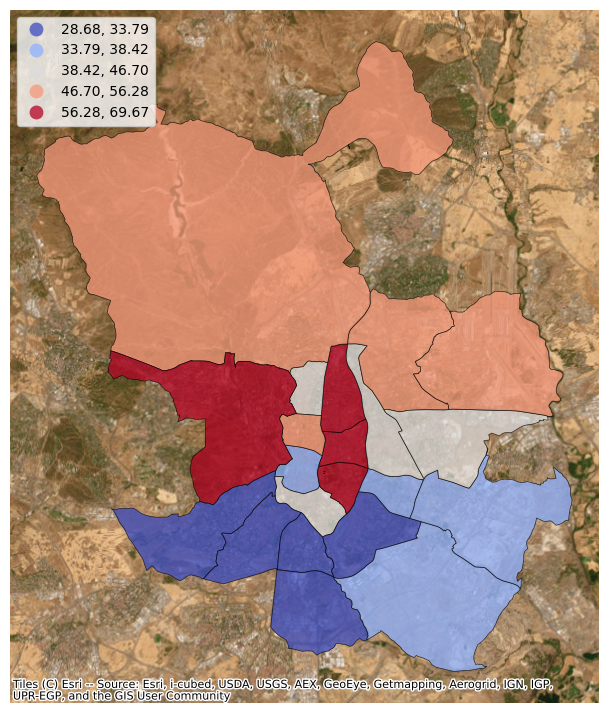

In [31]:
# Assuming 'merged' is your GeoDataFrame with 'geometry' column
fig, ax = plt.subplots(1, figsize=(9, 9))

# Plot with quantiles classification
merged.plot(
    column="Total",        # Column for color coding
    cmap="coolwarm",        # Color map
    scheme="quantiles",    # Classification scheme
    k=5,                   # Number of classes
    edgecolor="black",     # Edge color
    linewidth=0.5,         
    alpha=0.75,            # Transparency
    legend=True,           # Show legend
    legend_kwds={"loc": "upper left"},  # Legend position
    ax=ax                  # Axis to plot on
)

# Add a basemap using contextily
ctx.add_basemap(
    ax, 
    crs=merged.crs,        # Use correct coordinate reference system
    source=ctx.providers.Esri.WorldImagery # ctx.providers.Esri.WorldImagery, ctx.providers.Esri.WorldTopoMap, ctx.providers.Esri.WorldStreetMap # Basemap source
)

ax.set_axis_off()  # Turn off axis labels
plt.show()


## Global and Local Moran's I

In [33]:
# Create spatial weights based on adjacency (Queen Contiguity)
w = Queen.from_dataframe(merged) # TODO: Check details on how to do this properly
w.transform = 'r'

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_48598/2715872178.py:8: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(merged) # TODO: Check details on how to do this properly


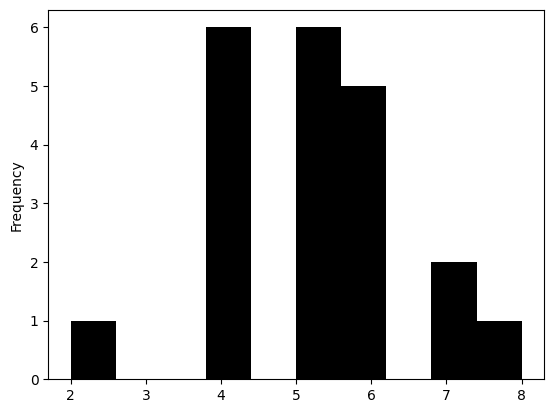

In [45]:
pd.Series(w.cardinalities).plot.hist(color="k");

I plot the Queen weights in the different districts of Madrid. The idea is to compare the weights for different methods: Queen, rock, KNN, etc.

(<Figure size 800x800 with 1 Axes>, <Axes: >)

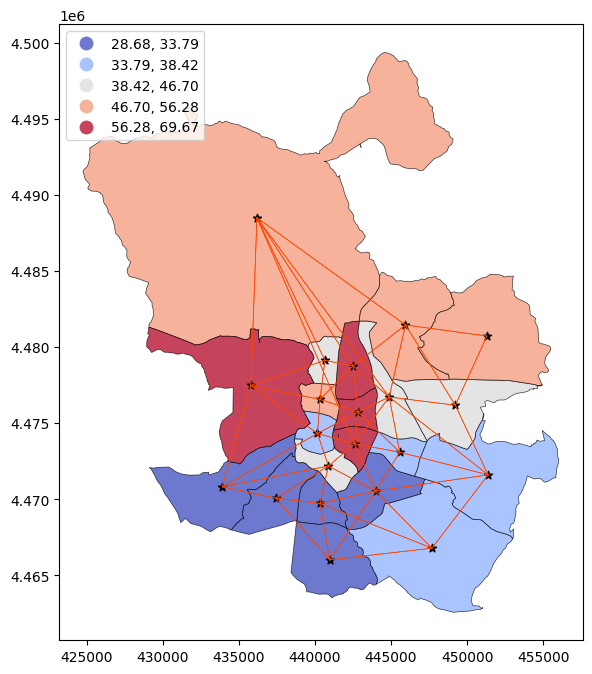

In [64]:
# Plot tract geography
f, ax = plt.subplots(1, figsize=(8, 8))
ax = merged.plot(
    column="Total",        # Column for color coding
    cmap="coolwarm",        # Color map
    scheme="quantiles",    # Classification scheme
    k=5,                   # Number of classes
    edgecolor="black",     # Edge color
    linewidth=0.5,         
    alpha=0.75,            # Transparency
    legend=True,           # Show legend
    legend_kwds={"loc": "upper left"},  # Legend position
    ax=ax                  # Axis to plot on
)
    # Plot graph connections
w.plot(
    merged,
    ax=ax,
    edge_kws=dict(linewidth=0.5, color="orangered"),node_kws=dict(marker="*")
)


I calculate and plot the Global Moran's I for renta neta media por hogar = 0.358, with a p-value of 0.002

Global Moran's I for renta neta media por hogar: 0.3580327301096283, p-value: 0.002


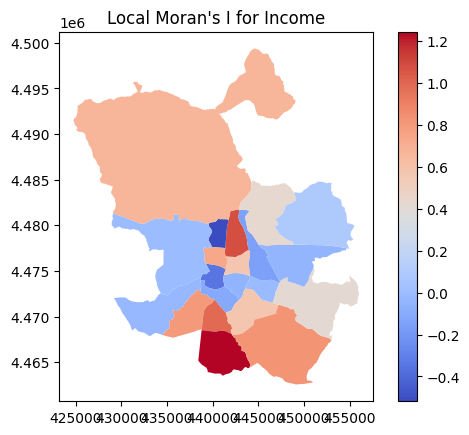

In [34]:
# Global Moran's I for income
mi_income = Moran(merged['Total'], w)
print(f'Global Moran\'s I for renta neta media por hogar: {mi_income.I}, p-value: {mi_income.p_sim}')


# Local Moran's I (LISA) for income
lisa_income = Moran_Local(merged['Total'], w)
gdf['lisa_income'] = lisa_income.Is  # Storing local Moran's I values in the GeoDataFrame
gdf['p_lisa_income'] = lisa_income.p_sim  # Storing p-values for LISA


# Plotting the LISA results
gdf.plot(column='lisa_income', cmap='coolwarm', legend=True)
plt.title('Local Moran\'s I for renta neta media por hogar')
plt.show()


#### Moran's Plot

COMPLETE: Why do I plot the Moran's plot? Why is this useful?

In [37]:
from libpysal.weights import lag_spatial
merged["mean_household_rent_std"] = merged["Total"] - merged["Total"].mean()
merged["mean_household_rent_lag_std"] = lag_spatial(
    w, merged["mean_household_rent_std"]
)

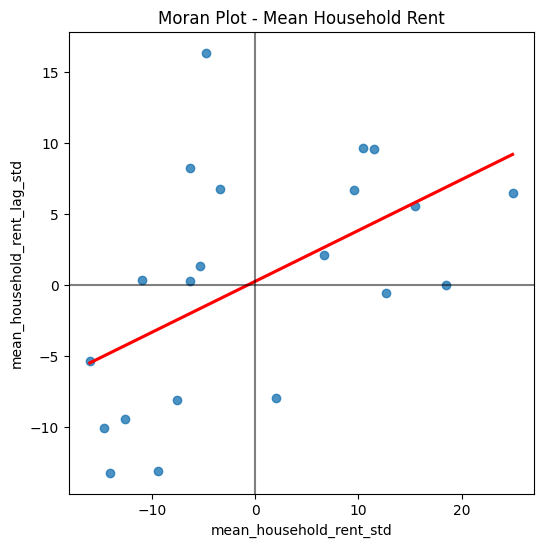

In [41]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x="mean_household_rent_std",
    y="mean_household_rent_lag_std",
    ci=None,
    data=merged,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - Mean Household Rent")
plt.show()


## Gini Index

In [ ]:
from segregation.spatial import Spatial_Gini

# Compute the Spatial Gini Index for Income
income_gini = Spatial_Gini(merged, group_pop_var='Total', total_pop_var='total_population')
print(f'Spatial Gini Index for Income: {income_gini.statistic}')


## Dissimilarity Index

In [ ]:
from segregation.spatial import SpatialDissim
index = SpatialDissim(gdf, 'HISP_', 'TOT_POP')
type(index)